<h2>Detecção de Outliers em Série Temporal - Radiação Solar</h2><br/>
Caráter do Problema: Não Supervisionado
<h4>Objetivos:</h4>
- Análise exploratória dos dados com foco em identificar anomalias em séries temporais
- Criar um modelo simples para identificar e classificar anomalias em séries temporais

In [1]:
# biblioteca para realizar manipulação de dados
import pandas as pd

# biblioteca para realizar cálculos matemáticos
import numpy as np

# biblioteca para realizar operações em datas
from datetime import datetime

# bibliotecas para realizar visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# configura para que os gráficos apareçam no mesmo notebook
%matplotlib inline

# configura o estilo padrão de visualização do sns
sns.set()

# biblioteca para normalização dos dados
from sklearn.preprocessing import StandardScaler

#biblioteca para redução de dimensionalidade
from sklearn.decomposition import PCA

# biblioteca de algoritmos não supervisionados 
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# função do statsmodels para decompor séries temporais
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\FelipeLima\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# leitura do dataset
df = pd.read_csv("solar_prediction.csv")

In [3]:
# visualização das cinco primeiras linhas
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
# exibe a quantidade de instâncias, os tipos dos atributos e o tamanho (MB) do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [5]:
# realiza algumas estatísticas descritivas para cada atributo (int ou float)
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


Percebe-se após a visualização do valor mínimo, máximo e quartis do atributo Radiation (Radiação), que o valor máximo provavelmente é um outlier.<br/>
É notório também, que o desvio padrão do atributo Pressure (Pressão) é muito baixo, ou seja, a variabilidade é baixa em relação a média.

In [6]:
# função que converte valores UNIXTime para datetime
def convert_unix_to_datetime(timeunix):
    return pd.to_datetime(datetime.utcfromtimestamp(timeunix))

In [7]:
# converte todas as instâncias do atributo UNIXTime em datetime, para conseguirmos trabalhar com as séries temporais
df['Date'] = df['UNIXTime'].apply(convert_unix_to_datetime)

In [8]:
# comprovando se as alterações foram realmente feitas
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Date
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-30 09:55:26
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-30 09:50:23
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-30 09:45:26
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-30 09:40:21
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-30 09:35:24


In [9]:
# captura os anos e meses do atribute Date
l_anos = []
l_meses = []
for i in range(len(df)):
    l_anos.append(df['Date'][i].strftime('%Y-%m-%d %H:%M:%S').split('-')[0][:4])
    l_meses.append(df['Date'][i].strftime('%Y-%m-%d %H:%M:%S').split('-')[1][:2])
serieAnos = pd.Series(l_anos)
serieMeses = pd.Series(l_meses)

In [10]:
# exibe quais meses no dataset existem e a respectiva quantidade de cada um
serieMeses.value_counts()

10    8701
11    8404
12    8044
09    7417
01     120
dtype: int64

In [11]:
# exibe quais anos no dataset existem e a respectiva quantidade de cada um
serieAnos.value_counts()

2016    32566
2017      120
dtype: int64

In [12]:
# verificando se existe algum dado ausente
df.isnull().sum().sort_values(ascending=False)

Date                      0
TimeSunSet                0
TimeSunRise               0
Speed                     0
WindDirection(Degrees)    0
Humidity                  0
Pressure                  0
Temperature               0
Radiation                 0
Time                      0
Data                      0
UNIXTime                  0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000009F602D00F0>,
      dtype=object)

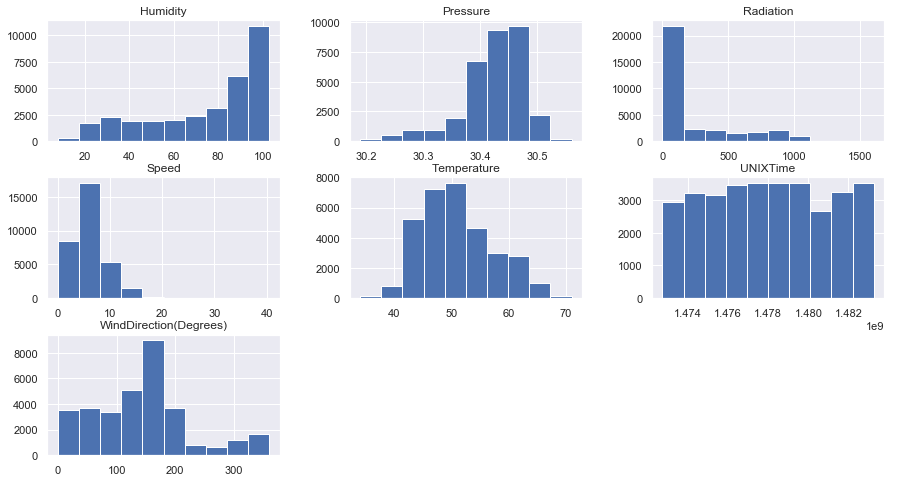

In [13]:
# visualização de todas as séries temporais do dataset
df.hist(figsize=(15,8))

C:\Users\FelipeLima\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


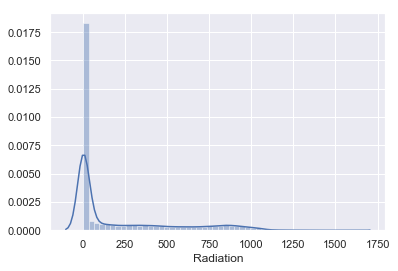

In [14]:
# plot da função de distribuição da Radiação
sns.distplot(df['Radiation'])

In [15]:
# eliminando alguns atributos que para esse momento não são importantes
dfs = df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]

In [16]:
# configurando o índice do dataframe para as datas
dfs.set_index(df['Date'], inplace=True)

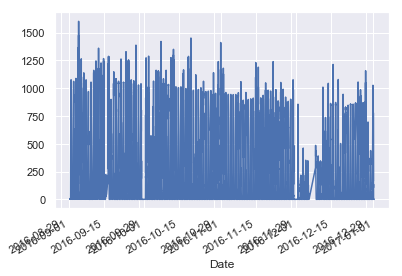

In [17]:
# plot da radiação em um gráfico de linhas para analisar a série temporal
dfs['Radiation'].plot(kind='line')

Text(0.5, 1.0, 'Série Temporal da Radiação por Data e Hora')

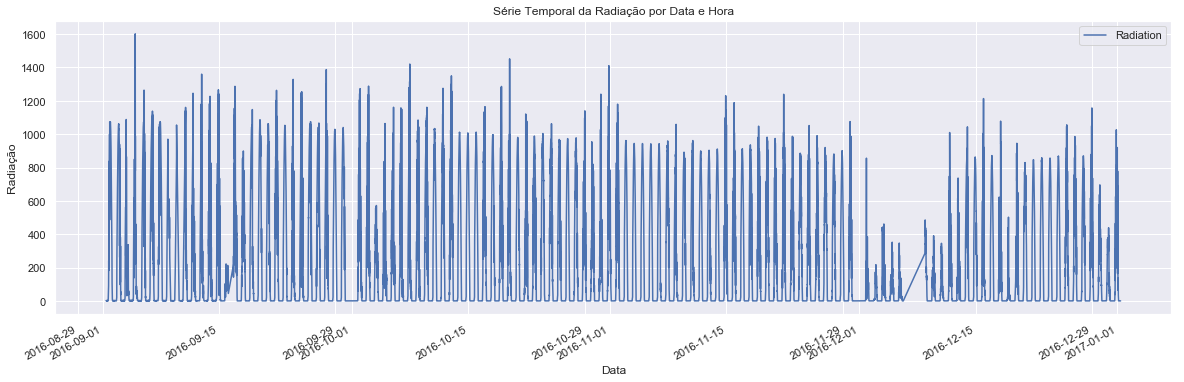

In [18]:
# melhorando a visualização da série temporal
df.plot(x='Date', y='Radiation', figsize=(20,6))
plt.xlabel('Data')
plt.ylabel('Radiação')
plt.title('Série Temporal da Radiação por Data e Hora')

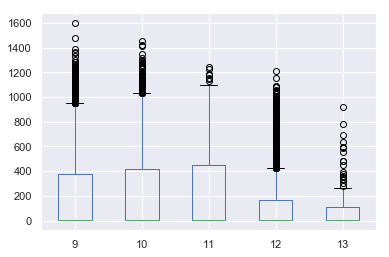

In [19]:
# boxplot de Radiação de cada mês, para visualizaçar os outlier

#ano = dfs['Radiation']['2016']
grupos = dfs['Radiation'].groupby(pd.Grouper(freq='M'))
meses = pd.concat([pd.DataFrame(x[1].values) for x in grupos], axis=1)
meses = pd.DataFrame(meses)
meses.columns = range(9,14)
meses.boxplot()
plt.show()

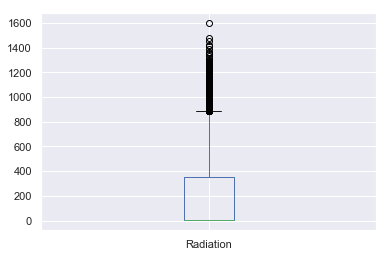

In [20]:
# boxplot para checar os residuos da Radiação como um todo
dfs['Radiation'].plot(kind='box')

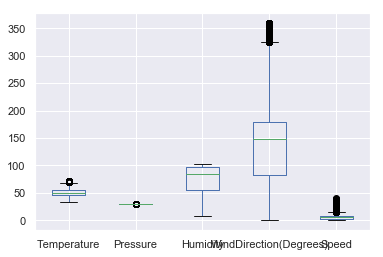

In [21]:
# boxplot para checar os restantes dos resíduos 
x = df[['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
x.set_index(df['Date'], inplace=True)
x.plot.box()

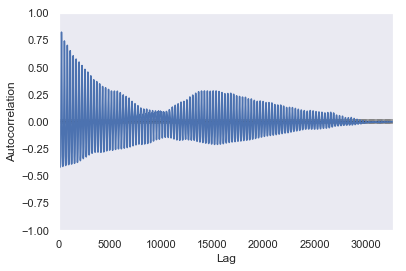

In [22]:
# plot da autocorrelação da série temporal radiação. Vemos que ela possui uma alta sazonalidade.
pd.plotting.autocorrelation_plot(dfs['Radiation'])
plt.show()

<h2>Construção do Modelo para Detecção de Anomalias</h2>
<h3>Algoritmo K-Means</h3>
O algoritmo k-means realiza tarefas não supervisionadas, ou seja, não é necessário rótulos (classe alvo) para se realizar classificações ou agrupamentos. É necessário definirmos antes de tudo, o valor do k, ou seja, quantos agrupamentos será feito.

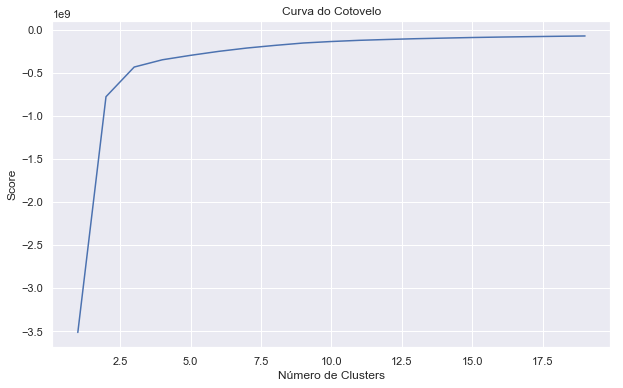

In [23]:
# Construindo uma Curva de Cotovelo para escolher o melhor número de agrupamentos (K)
dataset = df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(dataset) for i in n_cluster]
scores = [kmeans[i].score(dataset) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.title('Curva do Cotovelo')
plt.show();

Percebemos que a partir de 10 clusters, o gráfico se estabiliza, tendendo a uma constante, logo há pouquíssima explicação na variância. Portanto, vamos setar o valor para 9, pois é um número ímpar e adicionar mais teria pouca explicatividade no modelo.

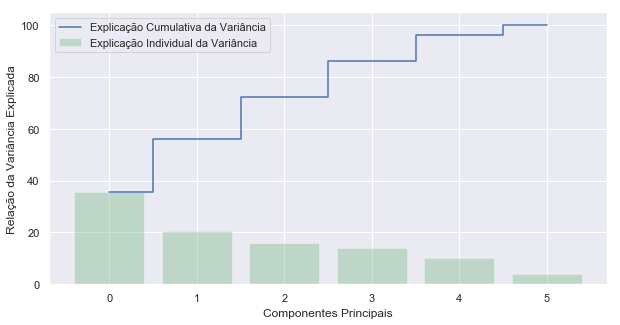

In [24]:
dataset = df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
X = dataset.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Explicação Individual da Variância
cum_var_exp = np.cumsum(var_exp) # Explicação Cumulativa da Variância

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='Explicação Individual da Variância', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Explicação Cumulativa da Variância')
plt.ylabel('Relação da Variância Explicada')
plt.xlabel('Componentes Principais')
plt.legend(loc='best')
plt.show()

Com a visualização deste gráfico, é notável que com duas dimensões obtém-se pouco mais de 50% de explicação dos dados. Com 4 dimensões, chega a ultrapassar os 80% de explicação!

In [25]:
# padronizando os valores
dataset = df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
X_std = StandardScaler().fit_transform(X)
dataset = pd.DataFrame(X_std)
# redução para 4 componentes principais, já que explica mais de 80% dos dados
pca = PCA(n_components=4)
dataset = pca.fit_transform(dataset)
# padronizando as 4 novas features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataset)
dataset = pd.DataFrame(np_scaled)

In [26]:
# verificando se realmente realizou os cálculos
dataset.head()

,0,1,2,3
0,-0.243185,0.156006,-1.204816,-0.407016
1,-0.248357,-0.248735,-1.238881,-0.817996
2,-0.193088,-0.315312,-1.260061,-0.646734
3,-0.165083,-0.464859,-1.214576,-0.412561
4,-0.082640,-0.232507,-1.171755,0.338891


In [27]:
# fitando vários modelos com diferentes k
kmeans = [KMeans(n_clusters=i).fit(dataset) for i in n_cluster]

# setando no atributo cluster qual cluster a instância está, utilizando o modelo com 9 clusters
df['cluster'] = kmeans[8].predict(dataset)
df.index = dataset.index

# criando 4 novos atributos no df
df['principal_feature1'] = dataset[0]
df['principal_feature2'] = dataset[1]
df['principal_feature3'] = dataset[2]
df['principal_feature4'] = dataset[3]

# quantas instâncias foram classificadas em clusters diferentes
df['cluster'].value_counts()

4    6873
5    5281
0    4905
6    4791
8    3078
7    2779
1    2637
2    1941
3     401
Name: cluster, dtype: int64

In [28]:
# retorna uma série de distância entre cada ponto e sua distância com o centróide mais próximo
def getDistanciaPonto(ds, model):
    distancia = pd.Series()
    for i in range(0,len(ds)):
        Xa = np.array(ds.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distancia.set_value(i, np.linalg.norm(Xa-Xb))
    return distancia

fracao_outliers = 0.01
# obtém a distância entre cada ponto e seu centróide mais próximo. As maiores distâncias são consideradas anomalias
distancia = getDistanciaPonto(dataset, kmeans[8])
numero_de_outliers = int(fracao_outliers*len(distancia))
threshold = distancia.nlargest(numero_de_outliers).min()
# anomalia1 contém o resultado da anomalia (0:normal, 1:anomalia) 
df['anomalia1'] = (distancia >= threshold).astype(int)

C:\Users\FelipeLima\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [29]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Date,cluster,principal_feature1,principal_feature2,principal_feature3,principal_feature4,anomalia1
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-30 09:55:26,5,-0.243185,0.156006,-1.204816,-0.407016,0
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-30 09:50:23,4,-0.248357,-0.248735,-1.238881,-0.817996,0
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-30 09:45:26,4,-0.193088,-0.315312,-1.260061,-0.646734,0
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-30 09:40:21,4,-0.165083,-0.464859,-1.214576,-0.412561,0
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-30 09:35:24,5,-0.082640,-0.232507,-1.171755,0.338891,0


In [30]:
# visualizando quantas anomalias existem. 0 para normal e 1 para outlier
df.anomalia1.value_counts()

0    32360
1      326
Name: anomalia1, dtype: int64

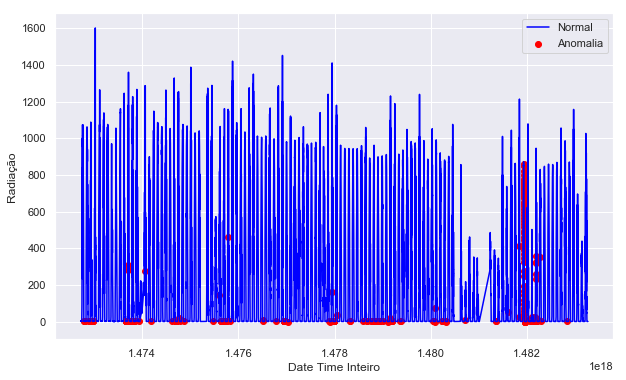

In [31]:
# plot da série temporal radiação, com suas anomalias detectadas

ds = df.sort_values('Date')
ds['DateTimeInt'] = ds.Date.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = ds.loc[ds['anomalia1'] == 1, ['DateTimeInt', 'Radiation']] #anomalia

ax.plot(ds['DateTimeInt'], ds['Radiation'], color='blue', label='Normal')
ax.scatter(a['DateTimeInt'],a['Radiation'], color='red', label='Anomalia')
plt.xlabel('Date Time Inteiro')
plt.ylabel('Radiação')
plt.legend()
plt.show()

<h2>Algoritmo Isolation Forest</h2>
As Florestas de Isolamento, assim como qualquer técnica de conjunto de árvores, é baseada em árvores de decisão. No qual seleciona aleatoriamente uma feature, em seguida, selecionando um valor de divisão aleatória entre o valor mínimo e máximo do recurso selecionado. Em princípio os outliers são menos frequentes nas observações. É por isso que usando tal particionamento aleatório eles devem ser identificados mais próximos da raiz da árvore (menor comprimento médio do caminho). <br/>
Retorna 1 para normal e -1 para anomalia.

C:\Users\FelipeLima\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\FelipeLima\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\FelipeLima\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\FelipeLima\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


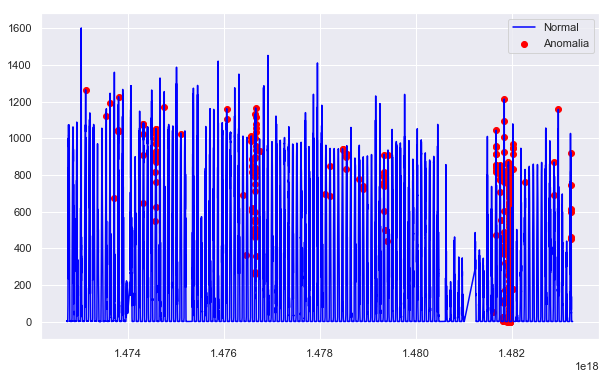

In [32]:
dataset = df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataset)
dataset = pd.DataFrame(np_scaled)
# treinando Isolation Forest
model =  IsolationForest(contamination=fracao_outliers)
model.fit(dataset)

df['anomalia2'] = pd.Series(model.predict(dataset))

fig, ax = plt.subplots(figsize=(10,6))

a = ds.loc[df['anomalia2'] == -1, ['DateTimeInt', 'Radiation']] #anomalia

ax.plot(ds['DateTimeInt'], ds['Radiation'], color='blue', label = 'Normal')
ax.scatter(a['DateTimeInt'],a['Radiation'], color='red', label = 'Anomalia')
plt.legend()
plt.show()

<h2>Algoritmo OneClass SVM</h2>
SVMs são associados geralmente a problemas supervisionados, porém o OneClass SVM, pode realizar tarefas não supervisionadas. Basicamente essa técnica separa todos os pontos de dados da origem (no espaço de features) e maximiza a distância deste hiperplano até a origem. 

C:\Users\FelipeLima\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\FelipeLima\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


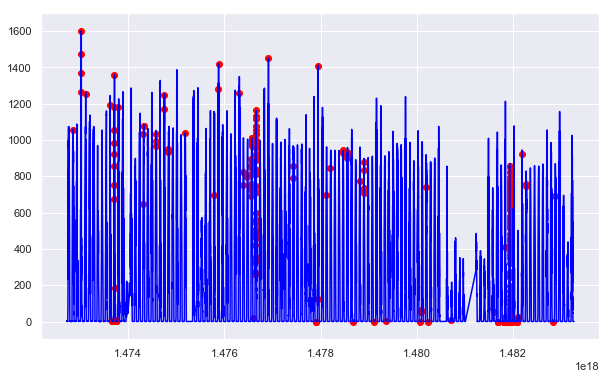

In [33]:
dataset = df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataset)
dataset = pd.DataFrame(np_scaled)
# treinando oneclassSVM 
model = OneClassSVM(nu=fracao_outliers, kernel="rbf", gamma=0.01)
model.fit(dataset)
df['anomalia3'] = pd.Series(model.predict(dataset))

fig, ax = plt.subplots(figsize=(10,6))
a = ds.loc[df['anomalia3'] == -1, ['DateTimeInt', 'Radiation']] #anomalia

ax.plot(ds['DateTimeInt'], ds['Radiation'], color='blue')
ax.scatter(a['DateTimeInt'],a['Radiation'], color='red')
plt.show()

Claramente, o algoritmo OneClass SVM obteve melhor desempenho do que os demais. Conseguiu identificar os picos da série temporal.